In [32]:
import os
import sys

In [33]:
# Detect if running in Google Colab environment.
# If so, then clone/install SmartStockRL package from GitHub.
# Otherwise, use locally.
try:
    import google.colab
    print('IN COLAB')

    # Clone repo.
    repo = "smart-stock-rl"
    repo_url = f"https://github.com/zanderman/{repo}.git"
    repo_path = f"/content/{repo}"
    !git clone --branch develop $repo_url

    # Install repo to ensure dependencies are resolved.
    !pip install --upgrade $repo_path

    # Add package location to path.
    sys.path.insert(0, repo_path)

    # Set dataset root path.
    dataset_root = '~/dataset'

except:
    dataset_root = '~/Desktop'
    print('NOT IN COLAB')

# Import package.
import smart_stock as ss

IN COLAB
fatal: destination path 'smart-stock-rl' already exists and is not an empty directory.
Processing ./smart-stock-rl
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for smart-stock: filename=smart_stock-0.0.1-py3-none-any.whl size=22641 sha256=3fd6074e3dbc14365ec2607527257a3464e9efe564c50354e1560b0c318c9757
  Stored in directory: /root/.cache/pip/wheels/5f/9a/51/d85d16e6e8cc024031e89ea4d0070e740e1d0cbc121406bacf
Successfully built smart-stock
  Attempting uninstall: smart-stock
    Found existing i

In [34]:
# Import other necessary packages after we know that imports are available.
from __future__ import annotations
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch

In [35]:
# Request user for Kaggle login if JSON file does not exist.
if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")) and os.environ["KAGGLE_USERNAME"] is None and os.environ["KAGGLE_USERNAME"] is None:
    import getpass
    username = getpass.getpass(prompt="Kaggle Username: ")
    api_key = getpass.getpass(prompt="Kaggle API KEY: ")
    os.environ["KAGGLE_USERNAME"] = username
    os.environ["KAGGLE_KEY"] = api_key

In [36]:
# Install future annotations for <3.7
if sys.version_info < (3,7):
    !pip install future-annotations

## Dataset

In [37]:
# Prepare dataset.
stocks = ['aapl', 'nvda', 'dis', 'ko', 'pg']
path = os.path.expanduser(dataset_root)
dataset = ss.datasets.HugeStockMarketDataset(path, quiet=False)

## Training Functions

In [38]:
def train(
    algo: ss.algorithms.qlearning.qsfm.Q_SFM, 
    env: gym.Env,
    max_episodes: int = 1000,
    max_steps: int = None,
    render: bool = False,
    render_mode: str = None,
    ) -> tuple[list[float], bool]:

    # List of reward values for plotting.
    rewards = []

    # Boolean solution flag.
    found_soln = False

    # Episode loop.
    for i in range(max_episodes):
        reward = algo.run_episode(max_steps=max_steps, render=render, render_mode=render_mode)
        rewards.append(reward)
        # if i%100 == 0: print(f'[{i}] {reward}')
        print(f'[{i}] {reward}')

    return rewards, found_soln

## Environment

In [39]:
# Create stock environment using specific stock.
df = dataset['aapl']
start_balance = 100
max_stock = 1 # 100
start_day = None
env_name = 'StockDataEnv'
env = ss.envs.StockDataEnv(
    df=df, 
    start_balance=start_balance, 
    max_stock=max_stock, 
    start_day=start_day,
)

In [40]:
# Make runs reproduceable.
RANDOM_SEED = 0 # Turn off by setting as `None`
if RANDOM_SEED is not None:
    env.seed(RANDOM_SEED)
    env.action_space.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

In [41]:
# Set tweakable parameters.
gamma = 0.9 # Discount factor (should be in (0,1)).
alpha = 0.0001 # Step size.
epsilon = 0.2 # Epsilon-greedy action selection (should be in (0,1)).

# Initialize linear function approximator by clipping low/high observation range.
order = 3
obs_low = np.clip(env.observation_space.low, -10, 10)
obs_high = np.clip(env.observation_space.high, -10, 10)
lfa = ss.mapping.fourier.FourierStateFeatureMapping(obs_low, obs_high, order)

# Create Q-learning algorithm agent with LFA.
agent = ss.algorithms.qlearning.qsfm.Q_SFM(env, lfa, gamma, alpha, epsilon)

100.0,0.0,0.0,1.1371,1.1449,1.1245,1.1371,43032322.0
100.0,100.0,0.0,1.1449,1.1487,1.0757,1.0847,119417272.0
100.0,100.0,0.0,1.0924,1.1128,1.0807,1.1128,73864294.0
98.90265361233713,100.0,1.0,1.1921,1.2167,1.1371,1.1768,201583820.0
98.90265361233713,100.07988454921555,1.0,1.1845,1.1884,1.1601,1.1768,82472624.0
100.08606122127696,100.08606122127696,0.0,1.1808,1.1845,1.1563,1.1718,32852867.0
98.90712286613757,100.08606122127696,1.0,1.1768,1.2128,1.1718,1.2089,59824201.0
97.72659887242116,100.08764685985398,2.0,1.2241,1.2677,1.1974,1.2485,132389122.0
98.9570720059871,100.18754513955304,1.0,1.2562,1.2562,1.2128,1.2241,48626504.0
97.7147483929873,100.1993956189869,2.0,1.2204,1.2614,1.2128,1.2294,58234350.0
98.94089243961848,100.16703648624966,1.0,1.2321,1.2361,1.2013,1.2013,64459467.0
97.71734066559442,100.16444421364255,2.0,1.2013,1.2013,1.1399,1.1655,77927956.0
96.54736656326699,100.05728887024928,3.0,1.1884,1.2321,1.1718,1.2037,91893088.0
97.74497574773355,100.14019411666665,2.0,1.1921,1

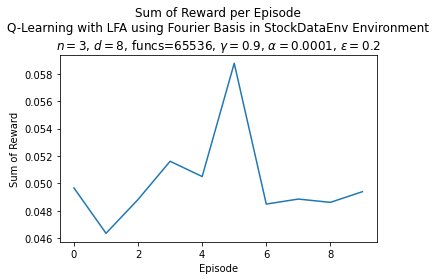

In [42]:
max_episodes = 10 # 1000 # Upper-limit on number of possible episodes.
max_steps = 50
render = True
render_mode = 'csv'

# Train the agent 
rewards, found_soln = train(agent, env, max_episodes, max_steps, render, render_mode)

# Plot the rewards.
plt.figure()
plt.plot(rewards)
plt.title(f"Sum of Reward per Episode\nQ-Learning with LFA using Fourier Basis in {env_name} Environment\n$n={order}$, $d={obs_low.size}$, funcs={lfa.coeffs.shape[0]}, $\gamma={gamma}$, $\\alpha={alpha}$, $\epsilon={epsilon}$")
plt.xlabel('Episode')
plt.ylabel('Sum of Reward')
plt.tight_layout()
plt.show()